In [1]:
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import statsmodels.api as sm

from scipy.stats import norm

In [2]:
import sys
sys.path.insert(0, '..')

In [3]:
from Optimizers.SampleWeighting import CauchySimplex, EGD, PairwiseFrankWolfe
from Optimizers.SampleWeighting.Distributions import TruncatedGaussian
from Optimizers.SampleWeighting.SampleWeighting import SampleWeighting

In [4]:
def theoretical_student_scores_std(p_values):
    num_students, num_questions = p_values.shape
    
    C = num_students * num_questions ** 2

    A = (np.sum(p_values * (1 - p_values)) + np.sum(p_values.T @ p_values)) / C
    B = (np.sum(p_values) / (num_students * num_questions)) ** 2

    return np.sqrt(A - B)

def theoretical_student_scores_mean(p_values):
    return np.mean(p_values)

In [5]:
def generate_student_scores(num_students=100, num_questions=100, 
                            easy_question_proportion=0.8, smart_student_proportion=0.6):
    # Question difficulty
    q_values = np.zeros(num_questions)
    n = int(num_questions * easy_question_proportion)

    q_values[:n] = 7 / 8
    q_values[n:] = 1 / 5

    # Student smartness
    s_values = np.zeros(num_students)
    n = int(num_students * smart_student_proportion)

    s_values[:n] = 4 / 5
    s_values[n:] = 1 / 2
    
    p_values = s_values[:, None] * q_values[None, :]
    
    return p_values

In [6]:
num_trials = 25

max_iter = 150
max_time = np.inf  # seconds

num_students = 200
num_questions = 75

p_values = generate_student_scores(num_students=num_students, num_questions=num_questions)

In [7]:
mean = theoretical_student_scores_mean(p_values)
std = theoretical_student_scores_std(p_values)

print(f"Mean = {mean:.4f}, Std = {std:.4f}")

Mean = 0.5032, Std = 0.1206


In [8]:
integration_points = np.linspace(0, 1, 401)
target_distribution = TruncatedGaussian(0.5, 0.1, 0, 1)

In [9]:
np.random.seed(0)

samples = np.random.binomial(1, p_values)
_, n = samples.shape

In [10]:
optimizer = CauchySimplex(samples, integration_points, target_distribution, e=0.05)
w = np.ones(n) / n

w_history = [(0, w.copy())]

for i in range(20):
    w = optimizer.search(w)
    
    if i == 1:
        w_history.append((i + 1, w.copy()))
        
w_history.append((i + 1, w.copy()))

In [11]:
for i, w in w_history:
    marks = samples @ w
    
    mean = np.mean(marks)
    std = np.std(marks)
    
    print(f"Iteration {i}: Mean = {mean:.3f}, Std = {std:.3f}")

Iteration 0: Mean = 0.499, Std = 0.128
Iteration 2: Mean = 0.514, Std = 0.124
Iteration 20: Mean = 0.501, Std = 0.109


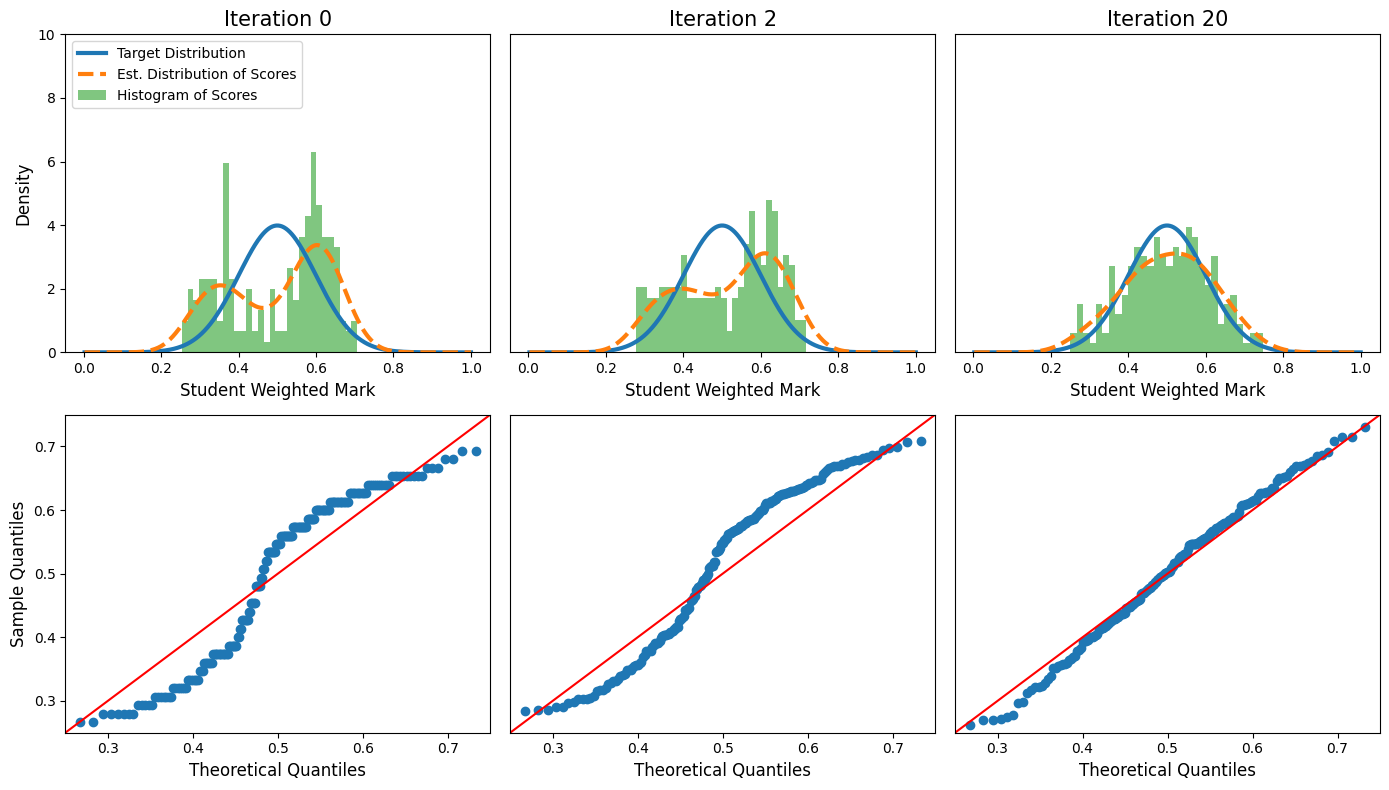

In [12]:
x_vals = integration_points[1:]

fig, axs = plt.subplots(2, 3, figsize=(14, 8))

for i, (ax, (iteration, w)) in enumerate(zip(axs[0], w_history)):
    ax.plot(x_vals, optimizer.target_distribution(x_vals), label='Target Distribution', 
            zorder=3, linewidth=3)
    ax.plot(x_vals, optimizer.rho(w), label='Est. Distribution of Scores', 
            linestyle='--', zorder=3, linewidth=3)
    
    ax.hist(samples @ w, density=True, bins=30, label='Histogram of Scores', zorder=1, alpha=0.6)
    
    ax.set_ylim(0, 10)
    
    ax.set_title(f"Iteration {iteration}", size=15)
    ax.set_xlabel("Student Weighted Mark", size=12)
    
    if i > 0:
        ax.set_yticks([], [])
    else:
        ax.set_ylabel("Density", size=12)
        ax.legend(loc='upper left')
        
for i, (ax, (iteration, w)) in enumerate(zip(axs[1], w_history)):
    sm.qqplot(samples @ w, dist=norm(loc=0.5, scale=0.1), line="45", ax=ax)
    
    ax.set_xlim(0.25, 0.75)
    ax.set_ylim(0.25, 0.75)
    ax.set_xlabel("Theoretical Quantiles", size=12)
    
    if i > 0:
        ax.set_yticks([], [])
        ax.set_ylabel(None)
    else:
        ax.set_ylabel("Sample Quantiles", size=12)
    
plt.tight_layout()
plt.savefig("mark_distribution.png", dpi=150);